# Rotary Spectra

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import netcdf
from scipy import signal

In [2]:
fpath = '/gscratch/jisao/mclaret/GL64/'
gridU_k1 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridU_k1.nc','r')
gridV_k1 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridV_k1.nc','r')
gridU_k58 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridU_k58.nc','r')
gridV_k58 = netcdf.netcdf_file(fpath + 'GLazur64-T20_y2009m06_m11_gridV_k58.nc','r')

In [3]:
# verify data shapes
if gridU_k1.variables['vozocrtx'].shape == gridV_k1.variables['vomecrty'].shape:
    print('k1 component shapes match.')
else:
    print('k1 component shapes do not match.')

if gridU_k58.variables['vozocrtx'].shape == gridV_k58.variables['vomecrty'].shape:
    print('k58 component shapes match.')
else:
    print('k58 component shapes do not match.')

k1 component shapes match.
k58 component shapes match.


In [4]:
# coordinates to focus on
x=275; y=48; t0=0; t1=3648-1  # S1 eddy
#x=321; y=100; t0=0; t1=3648-1  # S2 eddy
#x=347; y=54; t0=0; t1=3648-1  # S3 eddy

# variables at k=1
nav_lon = gridU_k1.variables['nav_lon'][y-1, x-1].copy()          # longitude
nav_lat = gridU_k1.variables['nav_lat'][y-1, x-1].copy()          # latitude
U_k1 = gridU_k1.variables['vozocrtx'][t0:t1, 0, y-1, x-1].copy()  # zonal velocities at time zero
V_k1 = gridV_k1.variables['vomecrty'][t0:t1, 0, y-1, x-1].copy()  # meridional velocities at time zero

# variables at k=58
U_k58 = gridU_k58.variables['vozocrtx'][t0:t1, 0, y-1, x-1].copy()  # zonal velocities at time zero
V_k58 = gridV_k58.variables['vomecrty'][t0:t1, 0, y-1, x-1].copy()  # meridional velocities at time zero

gridU_k1.close()
gridV_k1.close()
gridU_k58.close()
gridV_k58.close()

In [5]:
# shape data for multidimensional fft (fft2)
k1_dat = np.stack((U_k1, V_k1), axis=1)
k58_dat = np.stack((U_k58, V_k58), axis=1)
print(U_k1[0], V_k1[0])
print(k1_dat[0])

-0.065462895 -0.05654533
[-0.06546289 -0.05654533]


In [6]:
maxt = len(U_k1)
dt = 1.0  # 1-hour resolution
T = (maxt-1)*dt
times = np.arange(1,maxt+1,1) * 1.0
print('maxt = ', maxt)
print('times = ', times)

maxt =  3647
times =  [1.000e+00 2.000e+00 3.000e+00 ... 3.645e+03 3.646e+03 3.647e+03]


In [7]:
omega = 7.2921e-5
fCor = 2.*omega*np.sin((nav_lat)/180*np.pi)  # radians/sec
Tip = ((1./fCor) / 3600) * (2*np.pi)         # hours/cycle

print('fCor =', fCor)
print('Tip =', Tip)

fCor = 9.758121217882337e-05
Tip = 17.885914850042138


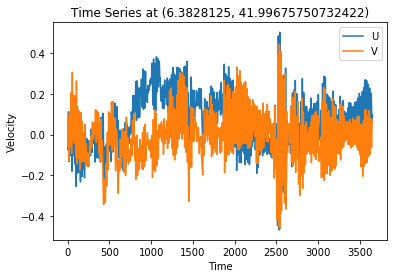

In [8]:
# plot time series of U and V
plt.figure()
plt.plot(times, k1_dat[:,0], label='U')
plt.plot(times, k1_dat[:,1], label='V')
#plt.xlim(0,400)

# plot labels
plt.title('Time Series at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.show()

In [9]:
alpha=0.2

# Tapered cosine windows
win1 = signal.tukey(len(U_k1),0)      # rectangular window
win2 = signal.tukey(len(U_k1),1)      # Hann window
win3 = signal.tukey(len(U_k1),alpha)  # 20% of points

# reshape windows
win1 = np.stack((win1, win1), axis=1)
win2 = np.stack((win2, win2), axis=1)
win3 = np.stack((win3, win3), axis=1)

In [10]:
# find amplitudes of Fourier coefficients
fc_k1 = np.fft.fft2(k1_dat*win3)            # k1 Fourier coefficients (FCs) w/ window
amp_k1 = fc_k1.real**2 + fc_k1.imag**2      # amplitude of k1 FCs
print(amp_k1)

fq_k1 = np.fft.fftfreq(times.shape[-1],dt)  # frequencies corresponding to each FC (cycles/h)
fq_k1_norm = fq_k1*2*np.pi/fCor/3600        # normalized to coriolis frequency

# rearrange data for plotting
amp_k1 = np.fft.fftshift(amp_k1)
fq_k1_norm = np.fft.fftshift(fq_k1_norm)
print(amp_k1)

[[41621.21425446 59737.80023986]
 [34344.39211672 17250.28854417]
 [22119.72674143 20083.43211416]
 ...
 [ 8557.93854889  1309.70405127]
 [22119.72674143 20083.43211416]
 [34344.39211672 17250.28854417]]
[[0.01028539 0.00967302]
 [0.00922564 0.00328056]
 [0.00049641 0.0003884 ]
 ...
 [0.00049641 0.0003884 ]
 [0.00922564 0.00328056]
 [0.01028539 0.00967302]]


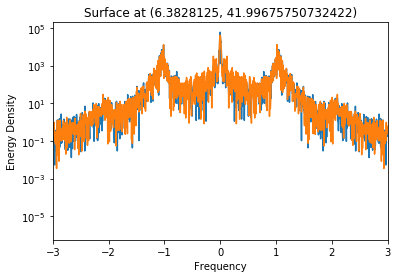

In [11]:
# plot rotary spectra at k1
plt.figure()
plt.plot(fq_k1_norm, amp_k1)
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('Surface at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
plt.show()

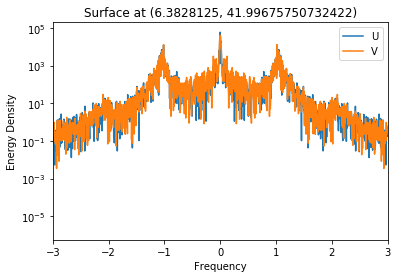

In [12]:
# plot rotary spectra at k1
plt.figure()
plt.plot(fq_k1_norm, amp_k1[:,0], label='U')
plt.plot(fq_k1_norm, amp_k1[:,1], label='V')
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('Surface at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
plt.legend()
plt.show()

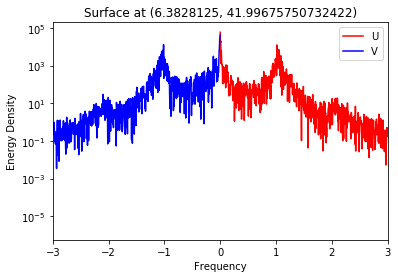

In [13]:
plt.figure()
# plot rotary spectra at k1
F_half = int(len(fq_k1_norm)/2)
plt.plot(fq_k1_norm[F_half:], amp_k1[:,0][F_half:], color='r', label='U')
plt.plot(fq_k1_norm[:F_half+1], amp_k1[:,1][:F_half+1], color='b', label='V')
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('Surface at ({}, {})'.format(nav_lon, nav_lat))
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
plt.legend()
plt.show()